In [1]:
"""
All tastes stacked
Different lambdas for each taste but same tau
SINGLE NEURON
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nSINGLE NEURON\n'

In [2]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [3]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing
(4, 30, 31, 7000)


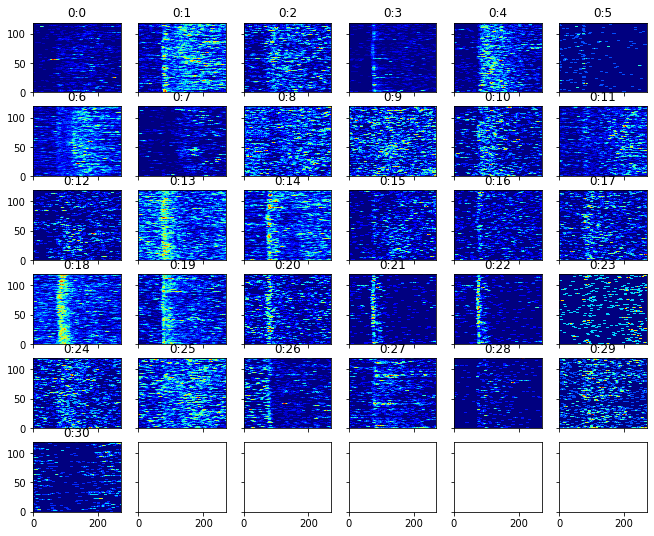

In [4]:
visualize.firing_overview(dat.all_normalized_firing);

In [95]:
nrn = np.arange(np.array(dat.spikes).shape[2])
taste_dat = np.array(dat.spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 31, 7000)


In [96]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)

(4, 30, 31, 80)


(4, 31, 80)


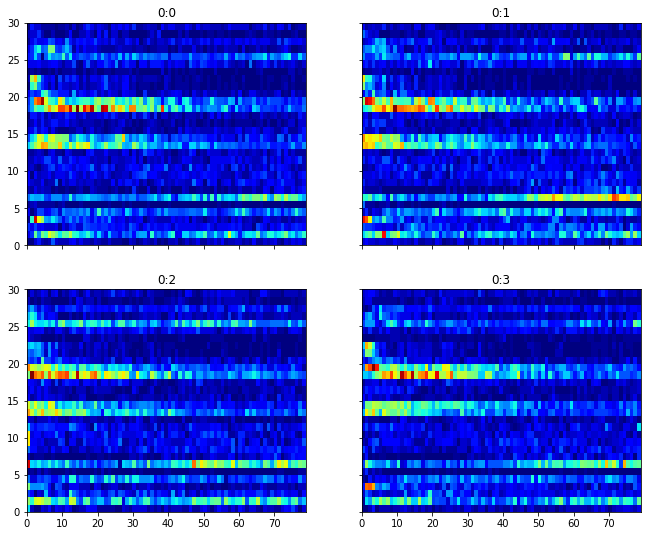

<Figure size 792x648 with 0 Axes>

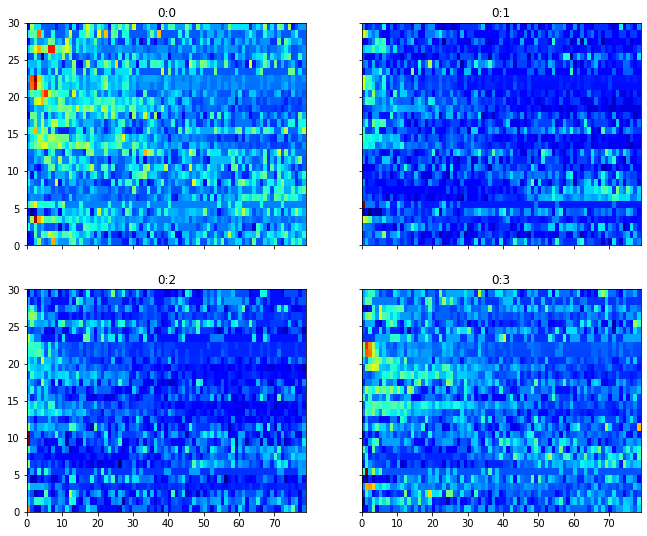

In [97]:
zscore_this_dat = np.array([stats.zscore(np.mean(nrn,axis=0),axis=None) \
                            for nrn in this_dat_binned.swapaxes(0,2)]).swapaxes(0,1)
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(zscore_this_dat.shape)
visualize.firing_overview(mean_this_dat);
plt.figure();
visualize.firing_overview(zscore_this_dat);

(120, 31, 80)


<Figure size 792x648 with 0 Axes>

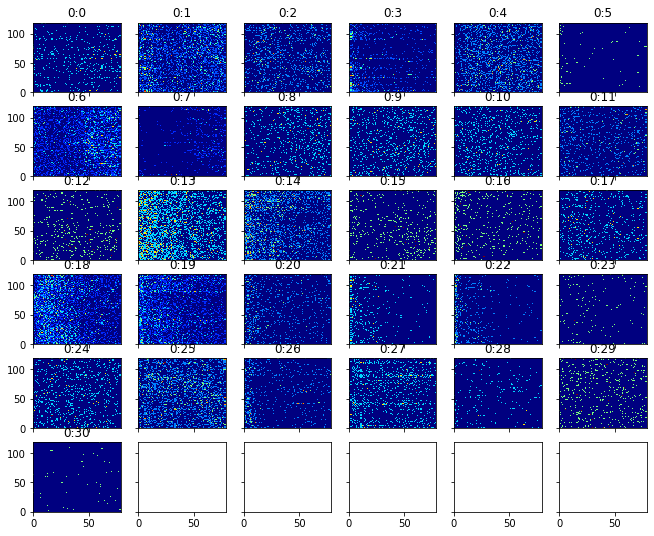

<Figure size 792x648 with 0 Axes>

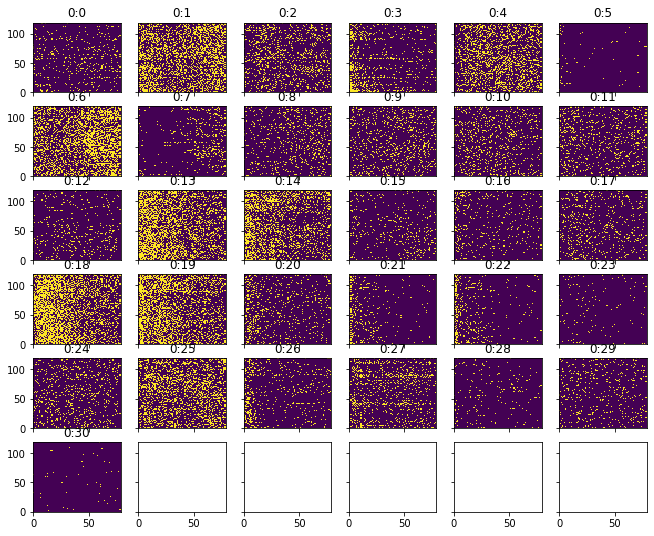

In [98]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
print(dat_binned_long.shape)
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='jet');
dat_binned_long[dat_binned_long>1] = 1
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [102]:
states = 4
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(4, 4, 30, 31, 20)
(4, 4, 31)
[[[0.10166667 0.435      0.15833333 0.32166667 0.21166667 0.035
   0.355      0.05       0.105      0.12666667 0.15166667 0.14333333
   0.07666667 0.60166667 0.46       0.09       0.105      0.125
   0.62166667 0.48333333 0.23       0.15666667 0.20333333 0.035
   0.12833333 0.28333333 0.25       0.17833333 0.06666667 0.07833333
   0.02      ]
  [0.05333333 0.26666667 0.17833333 0.13333333 0.28333333 0.01666667
   0.32333333 0.035      0.105      0.13       0.165      0.08666667
   0.10833333 0.45166667 0.355      0.055      0.05333333 0.11666667
   0.53833333 0.44166667 0.09666667 0.07833333 0.095      0.03
   0.15833333 0.27833333 0.06166667 0.11166667 0.06166667 0.09666667
   0.015     ]
  [0.07666667 0.35666667 0.145      0.08833333 0.26833333 0.01666667
   0.35666667 0.04       0.12       0.13333333 0.14333333 0.1
   0.08833333 0.32833333 0.18333333 0.09       0.045      0.07833333
   0.32666667 0.3        0.08333333 0.03       0.03       0.02666667
  

In [103]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(120, 31, 80)


In [104]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.   19.75 39.5  59.25 79.  ]
[0.25 0.5  0.75]


(31,)
(4, 31)
(4, 4, 31)


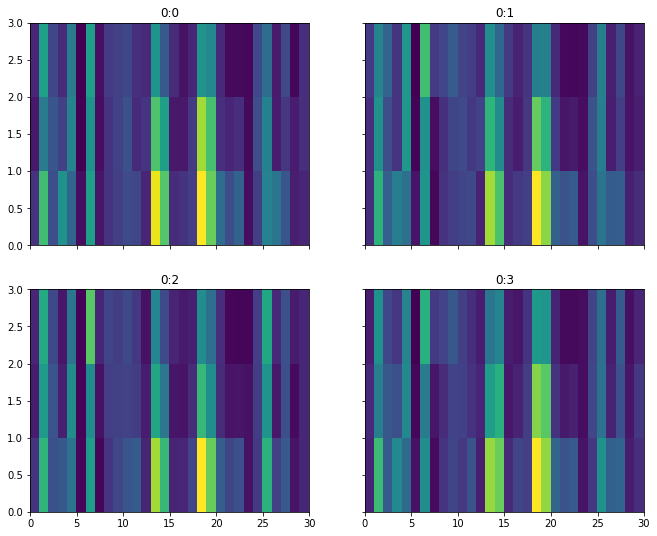

In [105]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
#     a_lambda = 2
#     b_lambda = 5
    # Priors for each neuron
    a_lambda = pm.HalfNormal('a_lambda',3, shape = (mean_vals.shape[-1]))
    b_lambda = pm.HalfNormal('b_lambda',3, shape = (mean_vals.shape[-1]))
    
    # Priors for each state, derived from each neuron
#     mu_lambda_state = pm.Beta('mu_lambda_state',a_lambda, shape = (mean_vals.shape[1:]))
#     sig_lambda_state = pm.HalfNormal('sig_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
    a_lambda_state = pm.HalfNormal('a_lambda_state',a_lambda, shape = (mean_vals.shape[1:]))
    b_lambda_state = pm.HalfNormal('b_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
    
    lambda_latent = pm.Beta('lambda', a_lambda_state, b_lambda_state, 
                            testval = mean_vals, 
                            shape = (mean_vals.shape))

print(a_lambda.tag.test_value.shape)
print(a_lambda_state.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

visualize.firing_overview(lambda_latent.tag.test_value,cmap='viridis');

In [106]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 3)


In [107]:
print(array_idx.shape)

(120, 31, 80)


In [108]:
print(tt.tile(array_idx,(3,1,1,1)).swapaxes(0,1).tag.test_value.shape)

(120, 3, 31, 80)


In [109]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])

#     tau = tau[...,np.newaxis,np.newaxis]
#     weight_stack = tt.nnet.sigmoid(tt.tile(array_idx,(states-1,1,1,1)).swapaxes(0,1) - tau)
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 31, 80)
(4, 4, 31)


In [110]:
weight_1_test =  weight_1_stack.tag.test_value[0]
lambda_latent_test = lambda_latent.tag.test_value[0]
print(weight_1_test.shape)
print(lambda_latent_test.shape)

(31, 80)
(4, 31)


In [111]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
#     # 3 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
    # 4 states
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
                np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])

#     lambda_latent_temp = lambda_latent[taste_label,:,:,np.newaxis]
#     print(lambda_latent.tag.test_value.shape)
#     print(lambda_latent_temp.tag.test_value.shape)
    
#     lambda_ = np.multiply(1 - weight_stack[:,0], lambda_latent_temp[:,0]) + \
#                 np.multiply(weight_stack[:,0] * (1 - weight_stack[:,1]), lambda_latent_temp[:,1]) + \
#                 np.multiply(weight_stack[:,1] * (1 - weight_stack[:,2]), lambda_latent_temp[:,2]) + \
#                 np.multiply(weight_stack[:,2], lambda_latent_temp[:,3])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]
(120, 31, 80)
(120, 31, 80)


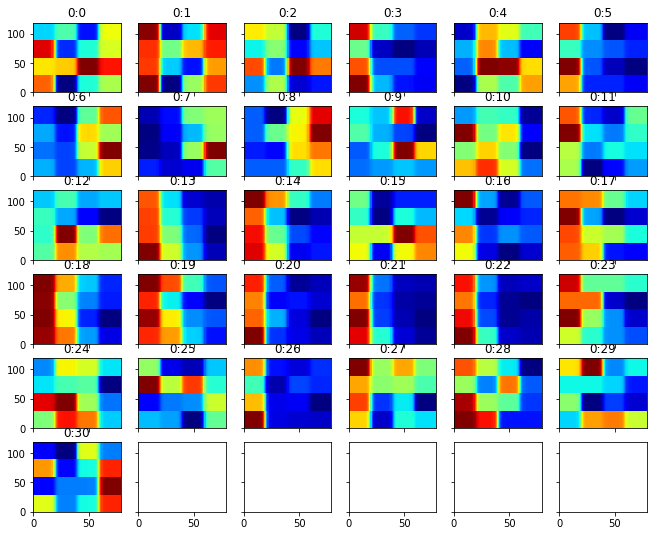

<Figure size 792x648 with 0 Axes>

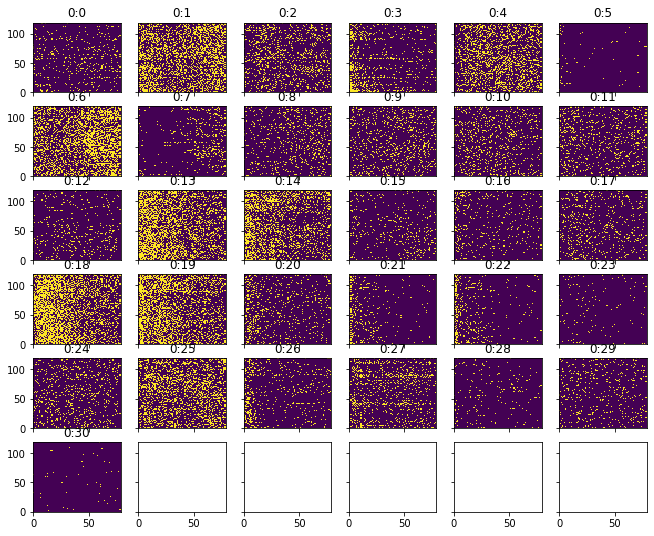

In [112]:
print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.firing_overview(lambda_.tag.test_value.swapaxes(0,1));
plt.figure()
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [113]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=dat_binned_long)

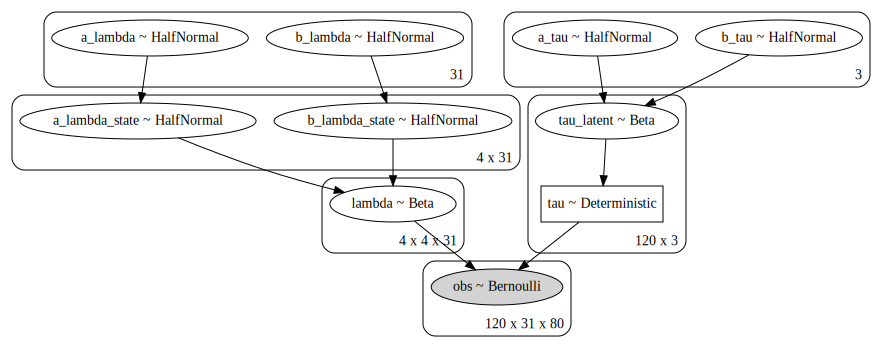

In [114]:
pm.model_to_graphviz(model)

In [116]:
with model:
    #step= pm.Metropolis()
    step= pm.NUTS()
    trace = pm.sample(1000, tune=100, 
                      step = step,
                      chains = 16, cores = 16)

Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda, b_lambda_state, a_lambda_state, b_lambda, a_lambda]
Sampling 16 chains, 0 divergences:  10%|▉         | 1678/17600 [45:24<7:10:55,  1.62s/draws] 
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


IndexError: index 5 is out of bounds for axis 0 with size 4

In [ ]:
print(trace['tau_latent'].shape)

In [ ]:
pm.autocorrplot(trace['tau_latent'][:,0,0]);

In [ ]:
pm.autocorrplot(trace['tau_latent'][::20,0,0]);

In [ ]:
# pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);
pm.forestplot(trace, var_names = ['a_tau','b_tau']);

In [ ]:
# pm.forestplot(trace[::100], var_names = 'tau');
# pm.forestplot(trace, var_names = 'tau');

In [ ]:
# pm.forestplot(trace[::100], var_names = ['a_lambda','b_lambda']);
pm.forestplot(trace, var_names = ['a_lambda','b_lambda']);

In [ ]:
# pm.forestplot(trace[::100], var_names = ['a_lambda','b_lambda']);
pm.forestplot(trace, var_names = ['a_lambda_state','b_lambda_state']);

In [ ]:
# pm.forestplot(trace[::100], var_names = ['lambda']);
pm.forestplot(trace, var_names = ['lambda']);

In [ ]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

In [ ]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

In [ ]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')



In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

In [ ]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

In [ ]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=1)
zscore_mean_mean_ppc = np.array([stats.zscore(nrn,axis=None) for nrn in mean_mean_ppc.swapaxes(0,1)]).swapaxes(0,1)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)
print(zscore_mean_mean_ppc.shape)

In [ ]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
    
# for this_ax in ax[-1,:]:
#     this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
#     this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [ ]:
zscore_mean_ppc = stats.zscore(mean_ppc, axis=(0,1))
print(zscore_mean_ppc.shape)

In [ ]:
# Overlay raster with CDF of switchpoints
trial_count = 30
raw_trial_inds = np.random.choice(np.arange(mean_ppc.shape[0]),trial_count, replace = False)
raw_taste_labels = taste_label[raw_trial_inds]
taste_label_sort = np.argsort(raw_taste_labels)
trial_inds = raw_trial_inds[taste_label_sort]

fig, ax = plt.subplots(trial_count,3,sharex=True, figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(dat_binned_long[trial],aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)

# for col in range(2):
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [ ]:
# For visualization
# Take firing around each transition and stack it together to make a PSTH (not mean firing)
# Before and after alignment
window_radius_time = 400 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau)

# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*count_data.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)
for trial in range(count_data.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < count_data.shape[-1]) + \
                                            count_data.shape[-1] * (upper_bound > count_data.shape[-1])
        
        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = count_data[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = count_data[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window
